In [25]:
%matplotlib inline
import os
import cv2
import sys
import time
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import numpy.random as rng
from imageio import imread
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import Sequential
from keras.engine.topology import Layer
from keras.layers.merge import Concatenate
from keras.initializers import glorot_uniform
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate

In [26]:
!wget https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_background.zip
!wget https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
!unzip images_background.zip >/dev/null
!unzip images_evaluation.zip >/dev/null
!rm images_background.zip images_evaluation.zip
!mkdir data
!mkdir weights

--2020-11-14 08:29:07--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_background.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9464212 (9.0M) [application/zip]
Saving to: ‘images_background.zip’

images_background.z 100%[===================>]   9.03M  --.-KB/s    in 0.07s   

2020-11-14 08:29:07 (122 MB/s) - ‘images_background.zip’ saved [9464212/9464212]

--2020-11-14 08:29:07--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 2

In [27]:
train_folder = "./images_background/"
val_folder = './images_evaluation/'
save_path = './data/'

In [28]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X =[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

### Loading the train images into tensors

In [29]:
X,y,c=loadimgs(train_folder)

loading alphabet: Hebrew
loading alphabet: Armenian
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Japanese_(katakana)
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Burmese_(Myanmar)
loading alphabet: Grantha
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Tagalog
loading alphabet: Cyrillic
loading alphabet: Futurama
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Arcadian
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Tifinagh
loading alphabet: Early_Aramaic
loading alphabet: Japanese_(hiragana)
loading alphabet: Gujarati
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Latin
loading alphabet: Balinese
loading alphabet: Bengali
loading alphabet: Korean
loading alphabet: Greek
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Sanskrit
loading alphabet: N_Ko
loading alphabet: Syriac_(Estrangelo)


In [30]:
print("We'll be using 964 characters for training the model out of 1632 characters,\n and each character has 20 samples per character \nhaving dimensions of 105x105, therefore its shape will be,\n ", X.shape, "\n\nAnd for each sample, there's the category (964*20), therefore its dimensions are:\n",y.shape)

We'll be using 964 characters for training the model out of 1632 characters,
 and each character has 20 samples per character 
having dimensions of 105x105, therefore its shape will be,
  (964, 20, 105, 105) 

And for each sample, there's the category (964*20), therefore its dimensions are:
 (19280, 1)


In [31]:
c.keys()

dict_keys(['Hebrew', 'Armenian', 'Malay_(Jawi_-_Arabic)', 'Japanese_(katakana)', 'Anglo-Saxon_Futhorc', 'Burmese_(Myanmar)', 'Grantha', 'Asomtavruli_(Georgian)', 'Tagalog', 'Cyrillic', 'Futurama', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Arcadian', 'Alphabet_of_the_Magi', 'Tifinagh', 'Early_Aramaic', 'Japanese_(hiragana)', 'Gujarati', 'Mkhedruli_(Georgian)', 'Latin', 'Balinese', 'Bengali', 'Korean', 'Greek', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Sanskrit', 'N_Ko', 'Syriac_(Estrangelo)'])

In [32]:
print('This holds the indexes of the corresponding chatacters in the c.keys()\n', c['Early_Aramaic'])

This holds the indexes of the corresponding chatacters in the c.keys()
 [503, 524]


### Saving the train tensors on disk

In [33]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

### Loading the validation images into tensors

In [34]:
Xval,yval,cval=loadimgs(val_folder)

loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Mongolian
loading alphabet: Keble
loading alphabet: Kannada
loading alphabet: Glagolitic
loading alphabet: Ge_ez
loading alphabet: Tengwar
loading alphabet: Malayalam
loading alphabet: Oriya
loading alphabet: Aurek-Besh
loading alphabet: Angelic
loading alphabet: Gurmukhi
loading alphabet: Atlantean
loading alphabet: Atemayar_Qelisayer
loading alphabet: Sylheti
loading alphabet: ULOG
loading alphabet: Manipuri
loading alphabet: Syriac_(Serto)
loading alphabet: Tibetan
loading alphabet: Avesta


In [35]:
Xval.shape

(659, 20, 105, 105)

### Saving the validation tensors on disk

In [36]:
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)

In [37]:
def initialize_weights(shape, dtype=None):
    """
    The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [38]:
def initialize_bias(shape, dtype=None):
    """
    The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

### Siamese Networks
![Model Architecture](https://miro.medium.com/max/2640/1*v40QXakPBOmiq4lCKbPu8w.png)

The two Convolutional Neural Networks shown above are not different networks but are two copies of the same network, hence the name Siamese Networks. Basically they share the same parameters. The two input images (x1 and x2) are passed through the ConvNet to generate a fixed length feature vector for each (h(x1) and h(x2)). Assuming the neural network model is trained properly, we can make the following hypothesis: If the two input images belong to the same character, then their feature vectors must also be similar, while if the two input images belong to the different characters, then their feature vectors will also be different. Thus the element-wise absolute difference between the two feature vectors must be very different in both the above cases. And hence the similarity score generated by the output sigmoid layer must also be different in these two cases. This is the central idea behind the Siamese Networks.

The `get_siamese_model()` creates the required model for implementing siamese network.


In [39]:
def get_siamese_model(input_shape):
    """
    Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [40]:
model = get_siamese_model((105, 105, 1))
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38947648    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential_1[0][0]    

In [41]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

### Loading the train tensors

In [42]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['Hebrew', 'Armenian', 'Malay_(Jawi_-_Arabic)', 'Japanese_(katakana)', 'Anglo-Saxon_Futhorc', 'Burmese_(Myanmar)', 'Grantha', 'Asomtavruli_(Georgian)', 'Tagalog', 'Cyrillic', 'Futurama', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Arcadian', 'Alphabet_of_the_Magi', 'Tifinagh', 'Early_Aramaic', 'Japanese_(hiragana)', 'Gujarati', 'Mkhedruli_(Georgian)', 'Latin', 'Balinese', 'Bengali', 'Korean', 'Greek', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Sanskrit', 'N_Ko', 'Syriac_(Estrangelo)']


In [43]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['Old_Church_Slavonic_(Cyrillic)', 'Mongolian', 'Keble', 'Kannada', 'Glagolitic', 'Ge_ez', 'Tengwar', 'Malayalam', 'Oriya', 'Aurek-Besh', 'Angelic', 'Gurmukhi', 'Atlantean', 'Atemayar_Qelisayer', 'Sylheti', 'ULOG', 'Manipuri', 'Syriac_(Serto)', 'Tibetan', 'Avesta']


The input to our system will be a pair of images and the output will be a similarity score between 0 and 1.\
Xi = Pair of images\
Yi = 1 ; if both images contain the same character\
Yi = 0; if both images contain different characters\
Like following:

![title](https://miro.medium.com/max/1100/1*4kfqL7aEvVMU0iALyxvG0g.png)


We'll be creating pairs of images along with the target variable, as shown above, to be fed as input to the Siamese Network. We will generate pairs randomly from all the alphabets in the training data.
The code to generate these pairs and targets is written in `get_batch()`

In [44]:
def get_batch(batch_size,s="train"):
    """
    Create batch of n pairs, half same class, half different class
    """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

`get_batch()` function by passing the batch_size and it will return “batch_size” number of image pairs along with their target variables.
We'll use it in `generate()` function to generate data in batches during the training of the network.

In [45]:
def generate(batch_size, s="train"):
    """
    a generator for batches, so model.fit_generator can be used. 
    """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

The model will be evaluated using **N way One shot Learning** 

![9 way](https://sorenbouma.github.io/images/task_9.png)

In the above image, we have 9 images in the support set, and we want to find the *character* in the left exist or not, then we will compare the similarity score of the character on the left with every character in the right.

The image with maximum similarity score in the support set will be the matching image.

Similarly, we can do this with 36 way One shot learning, i.e increasing the support set, given as below:

![25 way](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQoHaM9X0iFIg4bQCdxzPeaDcLhHKfaUxFmboDZuXCPiuvYXuqB)

The code for generating N way one shot learning, is written in `make_oneshot_task()`

In [46]:
def make_oneshot_task(N, s="val", language=None):
    """
    Create pairs of test image, support set for testing N way one-shot learning. 
    """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [47]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """
    Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks
    """
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [48]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [49]:
model_path = './weights/'

In [50]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 200 iterations: 0.3744197487831116 mins
Train Loss: 2.4782845973968506
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 27.6% 20 way one-shot learning accuracy 

Current best: 27.6, previous best: -1

 ------------- 

Time for 400 iterations: 0.8163727839787801 mins
Train Loss: 1.8820059299468994
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 44.0% 20 way one-shot learning accuracy 

Current best: 44.0, previous best: 27.6

 ------------- 

Time for 600 iterations: 1.25398192803065 mins
Train Loss: 1.5312182903289795
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 45.2% 20 way one-shot learning accuracy 

Current best: 45.2, previous best: 44.0

 ------------- 

Time for 800 iterations: 1.6989500403404236 mins
Train Loss: 1.2970855236053467
Evaluating model on 250 random 20 way one-s

### Load model weights

In [51]:
model.load_weights(os.path.join(model_path, "weights.20000.h5"))

### Testing

In [52]:
ways = np.arange(1,20,2)
trials = 50

In [53]:
val_accs, train_accs = [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 96.0% 3 way one-shot learning accuracy 

Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 100.0% 3 way one-shot learning accuracy 

---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average of 100.0% 5 way one-shot learning accuracy 

Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average of 100.0% 5 way one-shot learning accuracy 

---------------------

### Save the accuracies on disk

In [54]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs),f)

### Load the accuracies from disk

In [55]:
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs) = pickle.load(f)

### Below two functions are used for visualizing test image and support set

In [56]:
def concat_images(X):
    """
    Concatenates a bunch of images into a big matrix for plotting purposes.
    """
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [57]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

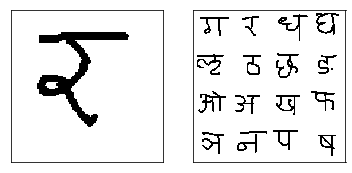

In [58]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(16,"train","Sanskrit")
plot_oneshot_task(pairs)

### Resuts

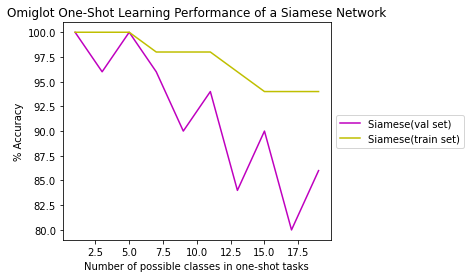

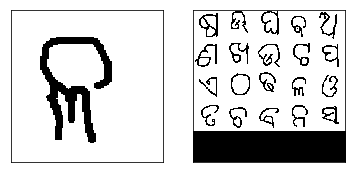

In [59]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

plot_oneshot_task(inputs)

In [60]:
#Accuracy
sum(val_accs)/len(val_accs)

91.6